<h1 align="center">Práctica 6. MF-sets</h1>
<h3 style="display:block; margin-top:5px;" align="center">Estructuras de datos</h3>
<h3 style="display:block; margin-top:5px;" align="center">Grado en Ciencia de Datos</h3>
<h3 style="display:block; margin-top:5px;" align="center">2023-2024</h3>    
<h3 style="display:block; margin-top:5px;" align="center">Universitat Politècnica de València</h3>
<br>

**Pon/poned aquí tú/vuestros nombre(s):**
- Pablo Pertusa Canales

## Índice
- ### [Introducción y objetivos](#intro)
- ### [Actividad 1: Contar componentes 4-conectadas y el nº pixels.](#act1)
- ### [Actividad 2: Obtener las *bounding boxes*](#act2)
- ### [Actividad 3: (ampliación opcional) Clasificar figuras](#act3)

<a id='intro'></a>
## Introducción: Objetivos de la práctica

El objetivo de esta práctica es utilizar la estructura de datos [MF-sets](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) para contabilizar el número de manchas de tinta [4-conectadas](https://en.wikipedia.org/wiki/Pixel_connectivity#4-connected) en una imagen (en blanco y negro, aunque se podría trabajar con escalas de gris o color) y algunas de sus características (nº de píxels y la caja que las engloba o [bounding box](https://en.wikipedia.org/wiki/Minimum_bounding_rectangle)). Esta tarea está muy relacionada con un problema llamado [Connected-component labeling (enlace a wikipedia)](https://en.wikipedia.org/wiki/Connected-component_labeling).

### Etiquetado de componentes conexas (connected-component labeling)

Este problema, muy útil en el campo de [Computer vision](https://en.wikipedia.org/wiki/Computer_vision), consiste en etiquetar los pixels de una imagen de manera que todos los pixels de cada componente 4-conectada de la imagen compartan una misma etiqueta (y que cada componente tenga una etiqueta diferente).

En la figura siguiente puedes ver la diferencia entre 8-conectado (izquierda) y 4-conectado (derecha):

> **Nota:** En esta práctica solamente vamos a trabajar con componentes 4-conectadas, pero no sería difícil adaptarlo al caso de imágenes 8-conectadas, bastaría con considerar también los vecinos en diagonal.

La siguiente figura ilustra el *Connected-component labeling*:

- A la izquierda tenemos la imagen original en blanco y negro de la que queremos identificar sus componentes 4-conectadas y asociarles un identificador único.
- A su derecha vemos la misma imagen donde, a cada pixel, se le ha asociado una etiqueta (1,2,4,5,7) de modo que cada componente 4-conectada tiene todos sus pixels con la misma etiqueta.

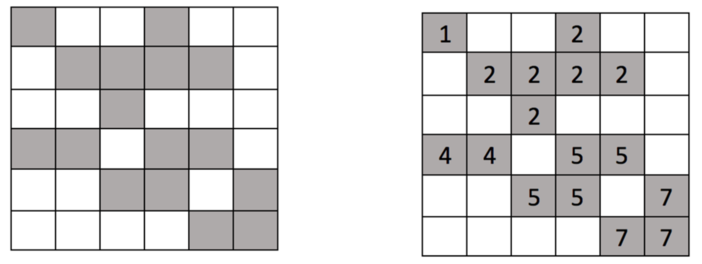

Existen varias formas de resolver este problema. Se podrían utilizar [algoritmos de recorridos de grafos](https://en.wikipedia.org/wiki/Graph_traversal#Graph_traversal_algorithms) como el [BFS](https://en.wikipedia.org/wiki/Breadth-first_search) o el [DFS](https://en.wikipedia.org/wiki/Depth-first_search), pero en esta práctica vamos a utilizar MF-sets y, más concretamente, el algoritmo de [Hoshen-Kopelman](https://en.wikipedia.org/wiki/Hoshen%E2%80%93Kopelman_algorithm)

La idea del algoritmo de Hoshen-Kopelman consiste en recorrer toda la imagen de arriba a abajo y, para cada fila, de izquierda a derecha. Nos detenemos únicamente en los pixels de tinta, que llamaremos el pixel *actual* en la descripción que sigue. Dado el pixel actual, observamos a dos de sus vecinos:

- El pixel que está **arriba** del actual.
- El pixel que está a la **izquierda** del actual.

> **Cuestión:** ¿Por qué es suficiente ver esos 2 pixels y no se comprueba el que tiene debajo ni el que tiene a su derecha?
**Porque como el algoritmo es de arriba a abajo, y en cada fila de izquierda a derecha, si hay un pixel de tinta contiguo ya sea horizontalmente o verticalmente, al comprobar dicho pixel arriba e izquierda, se detectará el pixel anterior, es decir no se dejan espacios sin comprobar.**

Entonces pueden suceder estos tres casos:

1. Ninguno de los pixels vecinos tiene tinta: En ese caso asociamos al pixel actual un identificador/etiqueta nuevo/a. Para ello podemos tener un contador con el que ir generando  identificadores (devolvemos ese valor y luego incrementamos el contador).
2. Solamente uno de los vecinos tiene tinta, el otro no: Copiamos el identificador/etiqueta del vecino al pixel actual.
3. Los dos vecinos tienen tinta: en ese caso nos copiamos uno de los dos identificadores pero, además, queremos que ambos identificadores se consideren a partir de ahora como formando parte de la misma componente 4-conectada, por lo que si no tenían el mismo valor tenemos que fusionarlos o hacer un *merge*.

Veamos cómo cargar una imagen en Python y qué aspecto tendría el algoritmo que etiqueta los pixels:

## Cómo cargar y manipular imágenes con la biblioteca `PIL.Image`:

El módulo `PIL` [(ver el siguiente enlace)](https://pillow.readthedocs.io/en/stable/) permite cargar, manipular y guardar imágenes en diferentes formatos. Veamos cómo cargar una imagen, lo primero es importarlo:

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

Ahora vamos a utilizar la clase `Image` de la biblioteca [PIL](https://pillow.readthedocs.io/en/3.1.x/reference/Image.html). Lo más sencillo es cargar una imagen con `Image.open`:

<class 'PIL.PngImagePlugin.PngImageFile'>
<class 'PixelAccess'>


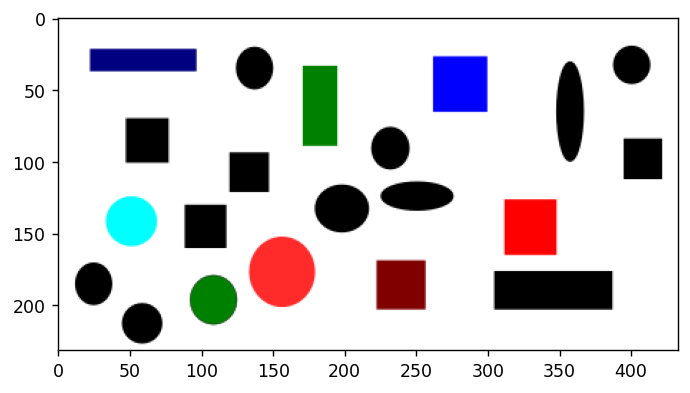

In [7]:
%matplotlib inline
img = Image.open("ejemplo_color.png")
plt.figure(dpi=125) # para que lo muestre un poco más grande
plt.imshow(img)
print(type(img))
p = img.load() # pixel access
print(type(p))

Veamos cómo se puede obtener el tamaño de la imagen:

In [8]:
width, height = img.size
print(f'imagen de talla {width} de ancho por {height} de alto')

imagen de talla 433 de ancho por 232 de alto


Podemos consultar el contenido de la imagen con el método `getpixel` o directamente con `[h,v]` aplicado a un objeto *pixel access*. El método `getpixel` recibe un sólo parámetro con una coordenada (una tupla) y devuelve un valor que depende del modo de la imagen. Para ver el modo de la imagen podemos hacer esto:

In [9]:
print(f'imagen con modo {img.mode}')

imagen con modo RGBA


Al tratarse del modo RGBA cada pixel vendrá dado por una tupla con 4 valores:

In [10]:
coordenada = (275,47)
pixel = img.getpixel(coordenada)
print(pixel) # (0, 0, 255, 255) color azul
pixel = p[150,180] # otra forma, usando p que es un pixel access de img
print(pixel) # (255, 42, 42, 255) pixel rojo del círculo rojo

(0, 0, 255, 255)
(255, 42, 42, 255)


Podemos convertir la imagen a grises así:

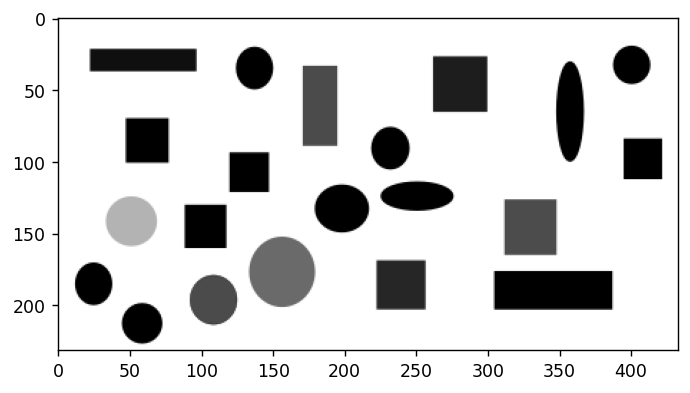

In [11]:
%matplotlib inline
gray_img = img.convert('I') # pasamos a escala de grises valores enteros
plt.figure(dpi=125) # para que lo muestre un poco más grande
plt.imshow(gray_img)

In [12]:
pixel = gray_img.getpixel(coordenada)
print(pixel)
p = gray_img.load()
print(p[10,10]) # este pixel es blanco, 255 es blanco

29
255


Ahora vamos a utilizar la del ejemplo utilizado para la *connected-component labeling*:

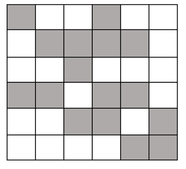

Una forma sencilla de obtener la imagen anterior sería escribirla directamente en formato PBM de tipo ASCII (ver [el siguiente enlace](https://en.wikipedia.org/wiki/Netpbm#File_formats)):

```
P1
# ejemplo 1
6 6
1 0 0 1 0 0
0 1 1 1 1 0
0 0 1 0 0 0
1 1 0 1 1 0
0 0 1 1 0 1
0 0 0 0 1 1
```

Pero aparentemente la biblioteca PIL de Python no es capaz de cargar un fichero en este formato, nos da el siguiente error:

```
raise UnidentifiedImageError(
PIL.UnidentifiedImageError: cannot identify image file 'ejemplo1.pbm'
```

Por lo que se os proporciona en poliformat la imagen anterior ya convertida a formato [PNG](https://en.wikipedia.org/wiki/Portable_Network_Graphics). Para generar esa imagen nosotros hemos utilizando la herramienta [convert](https://en.wikipedia.org/wiki/ImageMagick), es decir, con el siguiente comando:

```
convert ejemplo1.pbm ejemplo1.png
```

Junto a este notebook tienes el fichero `ejemplo1.png` y otros similares.

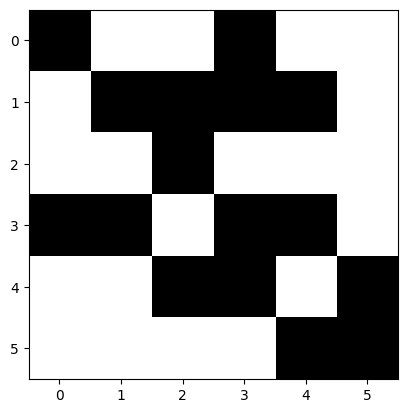

In [13]:
%matplotlib inline
img = Image.open("ejemplo1.png")
plt.imshow(img)

Observa que el siguiente código imprime básicamente la misma figura mostrando los niveles de gris (0 es negro y 255 es blanco):

In [14]:
width,height = img.size
p = img.load()
for w in range(height):
    for h in range(width):
        print(f"{p[h,w]:4}",end="")
    print()

   0 255 255   0 255 255
 255   0   0   0   0 255
 255 255   0 255 255 255
   0   0 255   0   0 255
 255 255   0   0 255   0
 255 255 255 255   0   0


<a id='act1'></a>
## Actividad 1: Contar componentes 4-conectadas y el nº pixels.

En lugar de etiquetar cada pixel de la imagen con una etiqueta única para cada componente conexa, vamos a limitarnos a **contar el número de componentes conexas 4-conectadas** que hay en la imagen y el número de pixels que tiene cada una.

La **entrada** del algoritmo será una imagen y un nivel de gris que llamaremos **umbral**. Todos los pixels que, pasados a gris, tengan un brillo menor o igual al umbral se consideran tinta, mientras que el resto de pixels se se considerarán fondo.

La **salida** del algoritmo es una lista donde, para cada componente 4-conectada de la imagen, vamos a proporcionar la siguiente información:

- Nº de pixels de tinta.

Para ello has de completar la clase `CountCC` que realiza la función de MF-set utilizando un diccionario Python llamado `self.parent` como representación del mismo.

La clase `CountCC`tiene los siguientes métodos:

- El constructor crea estos atributos:
    - `self.labelCount` sirve para ir generando etiquetas nuevas, puede inicializarse a 0.
    - `self.parent` es un diccionario (inicialmente vacío) que, **SOLAMENTE PARA LAS ETIQUETAS QUE NO SON REPRESENTANTE** indica quién es el padre de cada etiqueta. Si una etiqueta no es una clave de este diccionario significa que es un representante de su clase.
    - `self.numpixels` es **otro diccionario** que asocia al representante de cada clase el nº de pixels de esa componente conexa.
- El método `getNewLabel` nos devuelve una nueva etiqueta, en principio esa etiqueta es un representante de su clase. Para ello hace uso de `self.labelCount`. Aunque este método recibe las coordenadas del pixel que pide la nueva etiqueta, **en esta versión** no utilizar esos parámetros.
- El método `find` devuelve la etiqueta del representante de la clase. Para ello deberá ir subiendo a la raíz del árbol sabiendo que dicha raíz es una etiqueta que no tiene entrada en el diccionario `self.parent`.
- El método `merge` busca el representante de cada etiqueta y, si no son el mismo, hace que uno apunte al otro. **Este método devuelve el representante de la clase.**

    > **Importante:** al unir dos componentes distintas debes actualizar el nº de pixeles de la componente conexa de forma adecuada. Recuerda que si una etiqueta deja de ser representante debes eliminar su entrada en el diccionario `self.numpixels`. Esto se parece al ejercicio del boletín relacinado con la *unión por rango.*
    
- El método `addPixel` recibe una etiqueta y debe contabilizar un nuevo píxel en la clase de esa etiqueta. Para ello ha de incrementar el valor **del representante de dicha etiqueta** (debes llamar a `find`) en el diccionario `self.numpixels`.

    > **Nota:** el método `addPixel` recibe también un par de parámetros ancho y alto que vamos a ignorar de momento.


In [15]:
class CountCC:
    def __init__(self):
        self.labelCount = 0
        self.parent = {}
        self.numpixels = {}

    def getNewLabel(self, width, height):
        newLabel = self.labelCount
        self.labelCount += 1
        self.numpixels[newLabel] = 0 # no se cuenta el pixel aquí
                                     # pero sí se añade al diccionario
        return newLabel

    def find(self, x):
        """
        recibe una etiqueta
        devuelve la etiqueta representante de esa clase de equivalencia
        """
        while x in self.parent:
            x = self.parent[x]
        
        return x

    def merge(self, x, y):
        """
        recibe dos etiquetas
        hace que ambas formen parte de la misma clase de equivalencia
        devuelve la etiqueta representante
        """
        rx = self.find(x)
        ry = self.find(y)
        if rx != ry:
            self.parent[rx] = ry
            self.numpixels[ry] += self.numpixels[rx]
            del self.numpixels[rx]
        return ry
        
    def addPixel(self, label, width, height):
        self.numpixels[self.find(label)] += 1

    def getCCs(self):
        return list(self.numpixels.values())


La forma de comprobar el correcto funcionamiento de la clase anterior sería probando la siguiente fucnión que implementa el algoritmo de Hoshen-Kopelman:

In [16]:
def countCCImage( img, threshold=100, show=True, claseCCC=CountCC ):
    """
    receives a PIL image and a threshold
    returns a list with the number of pixels of each 4-connected component
    (Hoshen-Kopelman algorithm)
    """
    
    width, height = img.size
    p = img.load()
    ccc = claseCCC()

    def isInk(h, w):
        return 0<=h<height and 0<=w<width and p[w,h]<=threshold

    prevRowLabels = {}
    for h in range(height):
        rowLabels = {}
        for w in range(width):
            if isInk(h,w): # solo procesamos los pixels de tinta
                if isInk(h-1,w): # el pixel de arriba tb es tinta
                    label = prevRowLabels[w]
                    if isInk(h,w-1): # pixel izquierda tb es tinta
                        labelLeft = rowLabels[w-1]
                        label = ccc.merge(label, labelLeft)
                elif isInk(h,w-1): # solo pixel izquierda pero no arriba
                    label = rowLabels[w-1]
                else: # ni arriba ni izquierda hay tinta
                    label = ccc.getNewLabel(w,h)
                ccc.addPixel(label,w,h)
                rowLabels[w] = label
                if show: print(f"{label:2}",end="")
            else:
                if show: print(" .",end="")
        if show: print()
        prevRowLabels = rowLabels

    return ccc.getCCs()

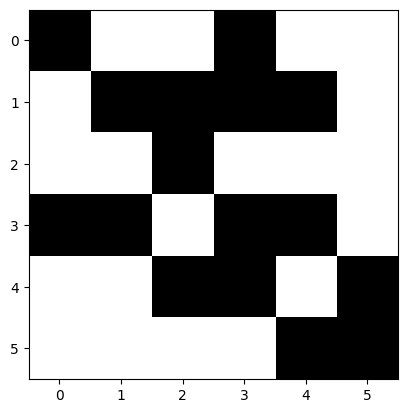

In [17]:
%matplotlib inline
img = Image.open("ejemplo1.png")
plt.imshow(img)

Y lo probamos con la imagen anterior:

In [18]:
img = Image.open("ejemplo1.png")
countCCImage(img)

 0 . . 1 . .
 . 2 2 2 2 .
 . . 2 . . .
 3 3 . 4 4 .
 . . 5 5 . 6
 . . . . 7 7


[1, 6, 2, 4, 3]

La ejecución anterior daría algo así:

```
 0 . . 1 . .
 . 2 2 2 2 .
 . . 2 . . .
 3 3 . 4 4 .
 . . 5 5 . 6
 . . . . 7 7

[1, 6, 2, 4, 3]
```

Es decir, imprime para cada pixel de tinta la etiqueta que se le ha asignado (observa que va generando valores consecutivos 0,1,2,...). Una vez finalizado el recorrido, devuelve una lista `[1, 6, 2, 4, 3]` que indica que hay una componente conexa con 1 pixel, otra con 6 píxeles, otra con 2, otra con 4 y otra con 3.

> **ATENCIÓN:** Observa que en la solución mostrada aparece una esquina así:
> ```
> . 4 4
> 5 5 .
> ```
>
> Es posible que tu solución saque las esquinas de forma diferente, por ejemplo:
>
> ```
> . 4 4
> 5 4 .
> ```
> Ambas soluciones son correctas y no tiene más importancia: depende únicamente de quién se ha puesto como representante en el proceso de `merge`.

<a id='act2'></a>
## Actividad 2: obtener las *bounding boxes*

La 2ª actividad consiste en modificar crear una clase `CountCCBB` que es una ligera modificación de la clase `CountCC`. Esta nueva clase hará uso de la siguiente clase `BoundingBox` y así tener, para cada componente conexa, no sólo el nº de píxels sino también la *bounding box* (ver [enlace](https://en.wikipedia.org/wiki/Minimum_bounding_box)) o la menor caja paralela a los ejes de coordenadas que incluye a dicha componente conexa:

In [19]:
class BoundingBox:
    def __init__(self, widthMin, heightMin, widthMax=None, heightMax=None):
        self.widthMin  = widthMin
        self.heightMin = heightMin
        self.widthMax  = widthMax or widthMin # None or algo devuelve algo
        self.heightMax = heightMax or heightMin

    def updateBB(self, other):
        # assert(isinstance(other, BoundingBox))
        self.widthMin  = min(self.widthMin, other.widthMin)
        self.widthMax  = max(self.widthMax, other.widthMax)
        self.heightMin = min(self.heightMin, other.heightMin)
        self.heightMax = max(self.heightMax, other.heightMax)
        
    def updatePixel(self, width, height):
        self.widthMin  = min(self.widthMin, width)
        self.widthMax  = max(self.widthMax, width)
        self.heightMin = min(self.heightMin, height)
        self.heightMax = max(self.heightMax, height)

    def __repr__(self):
        return f'BB({self.widthMin}, {self.heightMin}, {self.widthMax}, {self.heightMax})'

    def toTuple(self):
        return (self.widthMin, self.heightMin, self.widthMax, self.heightMax)
    
    def width(self):
        return self.widthMax - self.widthMin + 1

    def height(self):
        return self.heightMax - self.heightMin + 1
    
    def area(self):
        return self.width() * self.height()

    def center(self):
        return ((self.widthMin+self.widthMax)/2,(self.heightMin+self.heightMax)/2)

    def aspectRatio(self):
        return self.width()/self.height()


Es decir, la **nueva salida** del algoritmo Hoshen-Kopelman es una lista donde, para cada componente 4-conectada de la imagen, vamos a proporcionar la siguiente información:

- Nº de pixels de tinta (lo que ya devolvía antes).
- Bounding box en forma de los valores h_min, v_min, h_max, v_max (siendo h y v las coordenadas horizontal y vertical de la imagen, respectivamente).


Para ello debes añadir en el constructor de la clase `CountCC` un nuevo diccionario `self.bbox` que asocie, a cada etiqueta representante (a las otras no) la *bounding box* de su componente conexa. En particular, debes modificar los métodos:

- El constructor para añadir el nuevo diccionario `self.bbox`.
- El método `getNewLabel` para que asocie una bounding box a ese nuevo representante.
- El método `merge` porque solamente hay una bounding box para los representantes.
- El método `addPixel` que añade un nuevo pixel a una componente conexa y debe actualizar la bounding box correspondiente para tener en cuenta la coordenada del pixel añadido.
- El método `getCCs` ahora devuelve tuplas con el nº pixels y la bounding box asociada a dicha componente conexa.

Se aconseja copiar y pegar los métodos de la clase `CountCC` aquí debajo y adaptarlos cuando no sea posible reutilizar los de arriba directamente (nada que hacer gracias a la herencia) o simplemente llamar a super y añadir más funcionalidad aquí debajo:

In [20]:
class CountCCBB(CountCC):

    def __init__(self):
        super().__init__()
        self.bbox = {} # of each connected component

    # heredamos el método find

    # COMPLETAR resto de métodos...
    def getNewLabel(self, width, height):
        newLabel = self.labelCount
        self.labelCount += 1
        self.numpixels[newLabel] = 0 # no se cuenta el pixel aquí
                                     # pero sí se añade al diccionario
        
        box = BoundingBox(width, height)
        self.bbox[newLabel] = box
        return newLabel
    
    def merge(self, x, y):
        """
        recibe dos etiquetas
        hace que ambas formen parte de la misma clase de equivalencia
        devuelve la etiqueta representante
        """
        rx = self.find(x)
        ry = self.find(y)
        if rx != ry:
            self.parent[rx] = ry
            self.numpixels[ry] += self.numpixels[rx]
            del self.numpixels[rx]
            self.bbox[ry].updateBB(self.bbox[rx])
        
        return ry
        
    def addPixel(self, label, width, height):
        self.numpixels[self.find(label)] += 1
        self.bbox[self.find(label)].updatePixel(width, height)

    def getCCs(self):
        l = []
        for i in list(self.numpixels):
            l.append((self.numpixels[i],self.bbox[i]))
        return l

    

Con el nuevo código, la función `CountCCImageBB` (que delega en `CountCCImage` pero utiliza un objeto `CountCCBB`) devolvería lo que se muestra debajo:

In [21]:
def countCCImageBB( img, threshold=100, show=True):
    return countCCImage( img, threshold=100, show=show, claseCCC=CountCCBB)

In [22]:
img = Image.open("ejemplo1.png")
countCCImageBB(img)

 0 . . 1 . .
 . 2 2 2 2 .
 . . 2 . . .
 3 3 . 4 4 .
 . . 5 5 . 6
 . . . . 7 7


[(1, BB(0, 0, 0, 0)),
 (6, BB(1, 0, 4, 2)),
 (2, BB(0, 3, 1, 3)),
 (4, BB(2, 3, 4, 4)),
 (3, BB(4, 4, 5, 5))]

La ejecución anterior daría algo así:

```
 0 . . 1 . .
 . 2 2 2 2 .
 . . 2 . . .
 3 3 . 4 4 .
 . . 5 5 . 6
 . . . . 7 7

[(1, BB(0, 0, 0, 0)),
 (6, BB(1, 0, 4, 2)),
 (2, BB(0, 3, 1, 3)),
 (4, BB(2, 3, 4, 4)),
 (3, BB(4, 4, 5, 5))]
 ```
 
 Observa que ahora es una lista de tuplas. Cada tupla contiene un número de pixels y una "bounding box". El nº pixels coincide con el resultado del ejercicio anterior. Ahora se puede saber, por ejemplo, que la componente de 6 pixels de tinta 4-conectados se encuentra dentro de una bounding box `BB(1, 0, 4, 2)` con lo que podemos saber dónde está.

Otro ejemplo:

In [23]:
img = Image.open("ejemplo2.png")
countCCImageBB(img)

 . . . . . . . . . . . . . . . . . . . . . . . .
 . 0 0 0 0 . . 1 1 1 . . . 2 2 2 2 . . 3 3 3 3 .
 . 0 . . . . . 1 . . 4 . . 2 . . 2 . . 3 3 3 3 .
 . 0 0 0 0 . . 1 . . 4 . . 2 2 2 2 . . 3 3 3 3 .
 . 0 . . . . . 1 . . 4 . . 2 . . 2 . . 3 3 3 3 .
 . 0 0 0 0 . . 1 1 1 . . . 2 . . 2 . . 3 3 3 3 .
 . . . . . . . . . . . . . . . . . . . . . . . .


[(14, BB(1, 1, 4, 5)),
 (9, BB(7, 1, 9, 5)),
 (14, BB(13, 1, 16, 5)),
 (20, BB(19, 1, 22, 5)),
 (3, BB(10, 2, 10, 4))]

La salida anterior podría parecerse a algo así:

```
 . . . . . . . . . . . . . . . . . . . . . . . .
 . 0 0 0 0 . . 1 1 1 . . . 2 2 2 2 . . 3 3 3 3 .
 . 0 . . . . . 1 . . 4 . . 2 . . 2 . . 3 3 3 3 .
 . 0 0 0 0 . . 1 . . 4 . . 2 2 2 2 . . 3 3 3 3 .
 . 0 . . . . . 1 . . 4 . . 2 . . 2 . . 3 3 3 3 .
 . 0 0 0 0 . . 1 1 1 . . . 2 . . 2 . . 3 3 3 3 .
 . . . . . . . . . . . . . . . . . . . . . . . .

[(14, BB(1, 1, 4, 5)),
 (9, BB(7, 1, 9, 5)),
 (14, BB(13, 1, 16, 5)),
 (20, BB(19, 1, 22, 5)),
 (3, BB(10, 2, 10, 4))]
```

<a id='act3'></a>
## Actividad 3 (ampliación opcional) Clasificar figuras

Para el que tenga curiosidad, ahora ya tienes una forma de clasificar *más o menos* las figuras de la siguiente imagen en los siguientes tipos:

- círculo
- elipse
- cuadrado
- rectángulo

> **Nota:** Asumimos que únicamente tenemos estos 4 tipos de figura y que los rectángulos y cuadrados son paralelos a los ejes de coordenadas.


Para realizar la clasificación debemos determinar por separado:

- Para saber si es círculo/elipse o bien cuadrado/rectángulo vamos a dividir el nº pixels de tinta por el nº píxels de la bounding box. Si es un círculo/elipse la proporción se parecerá a la de un círculo de radio unidad (que tiene área $\pi$) dentro de una bounding box de área 4.
- Para determinar si es círculo/cuadrado o bien elipse/rectángulo hay que ver si el *aspect ratio* es cercano a 1 o bien se aleja de 1 por encima o por debajo.

> **Nota:** en ambos casos has de contemplar un ligero margen de *tolerancia* (ejemplo: $\pi/4$ es aproximadamente 0.78, pero puedes ver si la proporción de pixels de tinta supera el 0.9 para considerar que no es circular, de forma similar puedes considerar un rango del aspect ratio entre 0.8 y 1.2 para ser círculo/cuadrado).


In [24]:
def clasificaFigura(npix, bbox):
    """
    Recibe nº pixels y bounding box
    Devuelve una cadena entre 'circulo', 'elipse', 'cuadrado', 'rectangulo'
    """
    if npix/bbox.area() < 0.9:
        if bbox.aspectRatio() > 0.8 and bbox.aspectRatio() < 1.2:
            return 'circulo'
        return 'elipse'
    else:
        if bbox.aspectRatio() > 0.8 and bbox.aspectRatio() < 1.2:
            return 'cuadrado'
        return 'rectangulo'

Vamos a probar el clasificador de figuras con un ejemplo:

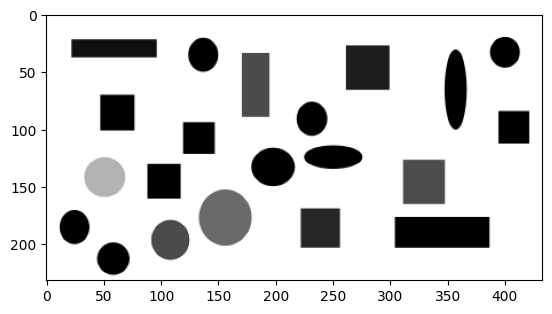

In [25]:
%matplotlib inline
img = Image.open("ejemplo_color.png").convert("I")
plt.imshow(img)

In [26]:
lista = countCCImageBB(img,show=False)
tipos = { 'circulo':[], 'elipse':[], 'cuadrado':[], 'rectangulo':[]}
for npix,bbox in lista:
    tipo = clasificaFigura(npix,bbox)
    tipos[tipo].append(bbox.center())

for tipo in ['circulo','elipse','cuadrado','rectangulo']:
    cuantos = len(tipos[tipo])
    plural = 's' if cuantos!=1 else ''
    oa = 'a' if tipo=='elipse' else 'o'
    print(f'Hay {cuantos} {tipo+plural} centrad{oa+plural} en:')
    for c in tipos[tipo]:
        print(" -",c)

Hay 7 circulos centrados en:
 - (400.5, 33.0)
 - (136.5, 35.0)
 - (231.5, 91.0)
 - (197.5, 133.0)
 - (24.5, 185.5)
 - (108.0, 196.5)
 - (58.5, 212.5)
Hay 2 elipses centradas en:
 - (357.0, 65.5)
 - (250.0, 124.5)
Hay 7 cuadrados centrados en:
 - (280.5, 46.5)
 - (61.5, 85.5)
 - (408.0, 98.5)
 - (133.0, 107.5)
 - (329.5, 145.5)
 - (103.0, 145.5)
 - (239.0, 186.5)
Hay 3 rectangulos centrados en:
 - (59.0, 29.5)
 - (182.5, 61.0)
 - (345.5, 190.0)
